图像构造，以及中变值可视化

2个目标标签
[0, 136, 251, 5, 5, 1.0, 0.8333786513282196, 0.3699339619574654, 0.46612981307265766, 0.07450971328930671, 0.3723331514916986, -2, 20, 192, 192]
[0, 246, 191, 5, 5, 1.0, 0.9704842037908517, 0.6599833324957911, 0.3761945110030009, 0.3096750477875, 0.21962491879812265, -2, 20, 192, 192]


<Figure size 2000x500 with 0 Axes>

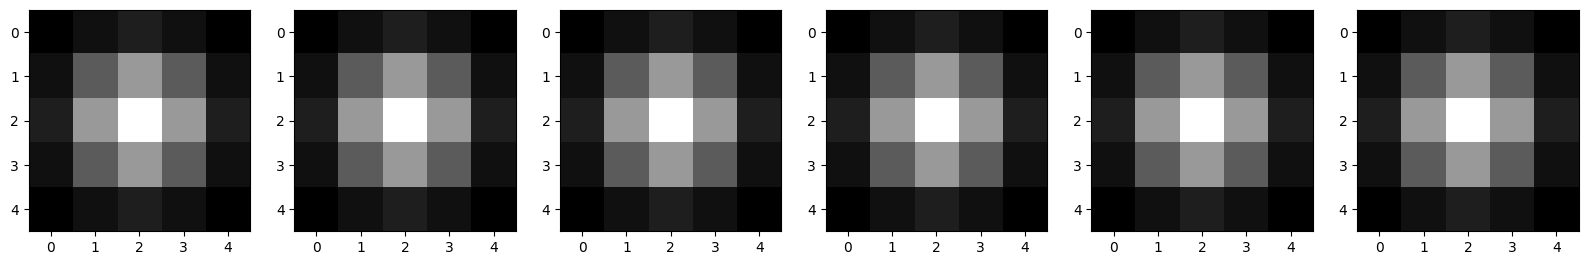

<Figure size 2000x500 with 0 Axes>

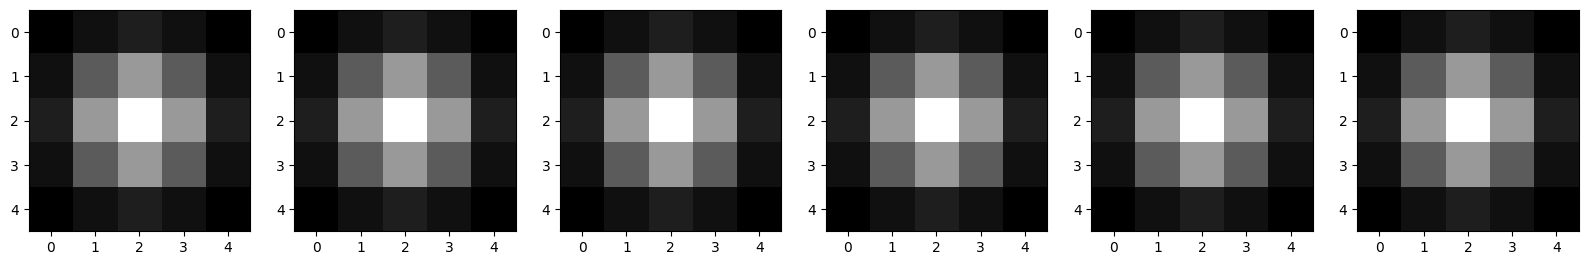

<Figure size 2000x500 with 0 Axes>

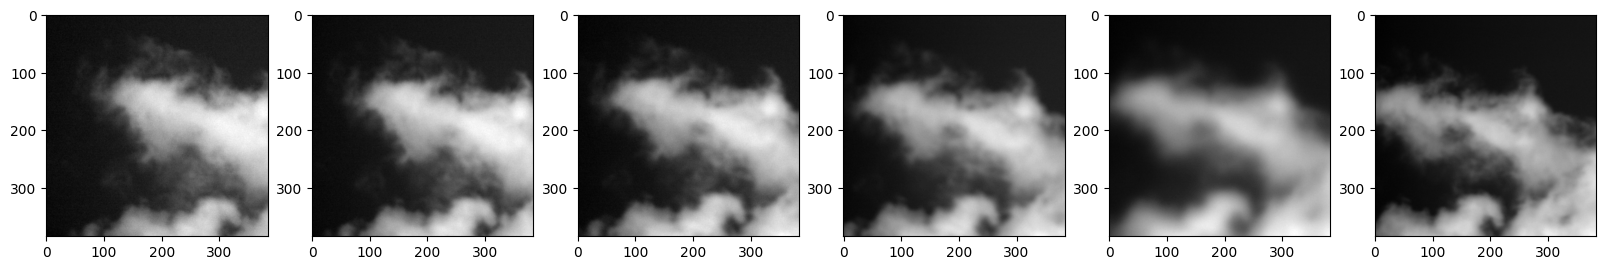

<Figure size 2000x500 with 0 Axes>

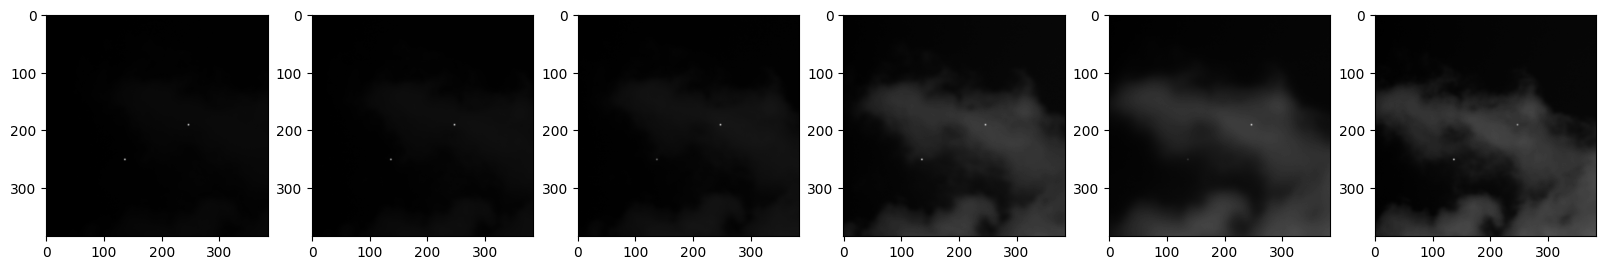

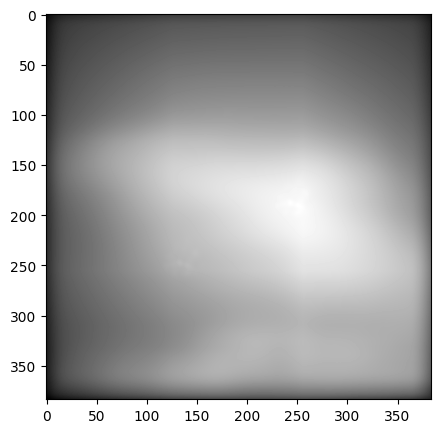

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils.PointSample import gen_merge_sample
import cv2
import os
import json
import scipy.io as sciio

otf_list = np.load("../data/PSF1110_6_IR_120_init.npy")
labels = [0]
obj_width = 5

sample, targets = gen_merge_sample(otf_list, labels, obj_width, point_type="gauss", weight_mode = "rand", have_noise = False , psnr=20, true_bg=True)

count = len(targets)
print("{}个目标标签".format(count))
for t in targets:    
    print(t)


##############目标图样###########

mat = dict()
for i in range(count):
    pt = np.load("debug/point_{}.npy".format(i))
    
    # mat["point"] = pt
    
    num, h,w = pt.shape
    plt.figure()
    plt.rcParams['figure.figsize'] = (20.0, 5.0)     
    fig, ax = plt.subplots(1,num)
    for j in range(num):
        ax[j].imshow(pt[j,:,:],cmap="gray")
        cv2.imwrite("debug/point_{}_{}.bmp".format(i, j), pt[j,:,:] * 255)


##############背景图样###########
bg = np.load("debug/background.npy")
# # mat["background"] = bg
# # sciio.savemat("background_and_point.mat",mat)

num, h,w = bg.shape
bg /=np.max(bg)
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
fig, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(bg[i,:,:],cmap="gray")
    cv2.imwrite("debug/background_{}.bmp".format(i), bg[i,:,:] * 255)



##############合成图样###########
rect_patch = np.load("debug/rect_patchs.npy")
num, h,w = rect_patch.shape
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
fig, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(rect_patch[i,:,:],cmap="gray")
    cv2.imwrite("debug/rect_patch_{}.bmp".format(i),rect_patch[i,:,:]/np.max(rect_patch[i,:,:]) * 255)


##############卷积结果###########
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
plt.imshow(sample[0,:,:],cmap="gray")
# cv2.imwrite("debug/sample.bmp".format(i), (sample[0,:,:] - np.min(sample[0,:,:])) / (np.max(sample[0,:,:])-np.min(sample[0,:,:]))  * 255)
cv2.imwrite("debug/sample.bmp".format(i), sample[0,:,:] * 255)

#############存储结果############
path = "debug"
np.save(os.path.join(path,"sample_{:05d}.npy".format(0)),sample)
with open(os.path.join(path,"sample_{:05d}.json".format(0)), "w") as fp:
    json.dump(targets, fp)


显示光谱压缩图像

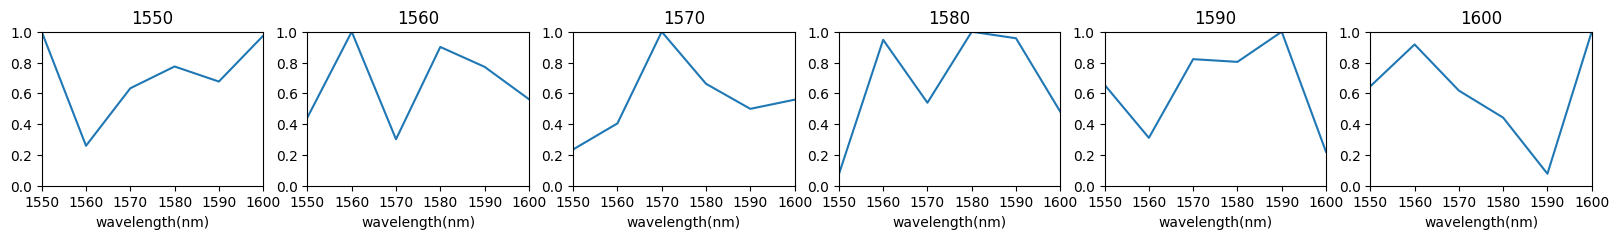

In [62]:

import matplotlib.pyplot as plt
import random
from lib.utils.PointSample import gen_weight_and_label

wave_count = 6
labels = [0,1,2,3,4,5]
x = [1550,1560,1570,1580,1590,1600]
fig, ax = plt.subplots(1,6)
for i in range(6):
    weight0 , label0 = gen_weight_and_label(wave_count, labels = [labels[i]], weight_mode="rand", have_noise = True)
    ax[i].plot(x,weight0)    
    ax[i].set_title(str(x[i]))
    ax[i].set_xlabel("wavelength(nm)")
    ax[i].set_xlim((1550,1600))
    ax[i].set_ylim((0,1))
plt.rcParams['figure.figsize'] = (20.0, 2.0) 
plt.xlim((1550,1600))
plt.show()

可视化显示

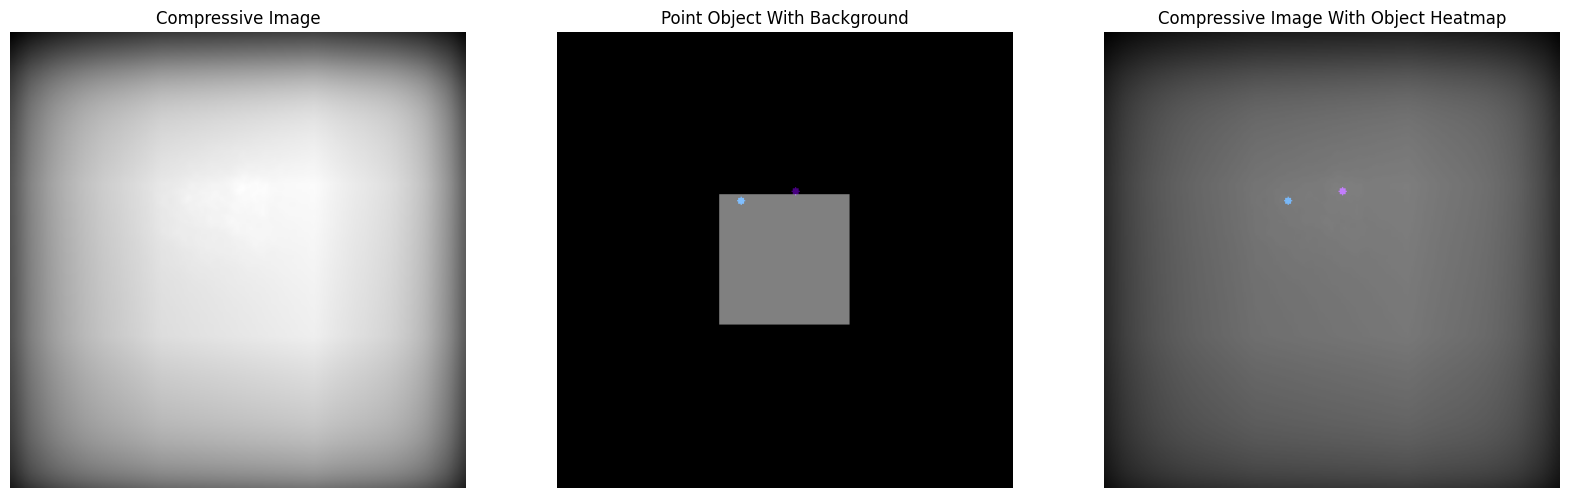

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from lib.utils.image import draw_umich_gaussian, draw_msra_gaussian


def gen_background(heatmap, anns, width = 111):
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    rectx = anns[0][-2]
    recty = anns[0][-1]

    x1 = rectx - width//2
    x2 = rectx + width//2
    y1 = recty - width//2
    y2 = recty + width//2
    mask[y1:y2, x1:x2, :] = 1
    return np.ascontiguousarray(mask * 255 , dtype=np.uint8)


def gen_color(cls):
    cmap = {0:(139, 0 , 255),
            1:(0, 0, 255), 
            2:(0, 127, 255), 
            3:(0, 255, 0), 
            4:(255, 255, 0), 
            5:(255, 0, 0)}
    return cmap[cls]


def add_gt_mask(heatmap, anns, radius=3, factor= 1.0): 
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    mask = np.ascontiguousarray(mask, dtype=np.uint8)
    for ann in anns:
        px = int(ann[1])
        py = int(ann[2])
        cls = int(ann[0])
        color = gen_color(cls)
        cv2.circle(mask, (px,py), radius, color,-1)
    return mask

for idx in range(1):
    # path = "../data/PSF0815_6_IR_30_nsr_0.1/"
    path = "debug/"
    img = np.load(os.path.join(path,"sample_{:05d}.npy").format(idx))
    with open(os.path.join(path,"sample_{:05d}.json".format(idx)), "r") as fp:
        gts = json.load(fp)
    c,h,w=img.shape
    
    # Heatmap
    heatmap = np.zeros((h,w))
    backgroud = gen_background(heatmap, gts)

    points_mask = add_gt_mask(heatmap, gts, radius=3)

    # image
    img = np.concatenate((img,img,img), axis=0)
    img = img.transpose(1,2,0)*255
    img = np.ascontiguousarray(img, dtype=np.uint8)

    # object 
    obj = cv2.addWeighted(backgroud, 0.5, points_mask, 0.5, 0)

    # image + heatmap
    merge = cv2.addWeighted(img, 0.5, points_mask, 0.5, 0)

    # plot
    fig, ax = plt.subplots(1,3)    
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("Compressive Image")
    ax[1].imshow(obj)
    ax[1].axis("off")
    ax[1].set_title("Point Object With Background")
    ax[2].imshow(merge)
    ax[2].axis("off")
    ax[2].set_title("Compressive Image With Object Heatmap")
    cv2.imwrite("debug/img.bmp",cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
    cv2.imwrite("debug/object.bmp",cv2.cvtColor(obj, cv2.COLOR_RGB2BGR) )
    cv2.imwrite("debug/merge.bmp",cv2.cvtColor(merge, cv2.COLOR_RGB2BGR) )
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.show()


数据分布分析

In [2]:
import json
import os
import numpy as np
count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}
point_count = {1:0, 2:0, 3:0}
distance = list()

for idx in range(9000):
    path = "../data/PSF0815_6_IR_30_nsr_0.1/"
    # path = "."
    with open(os.path.join(path,"sample_{:05d}.json".format(idx)), "r") as fp:
        gts = json.load(fp)
    for gt in gts:
        for k, v in count.items():
            if k == gt[0]:
                count[k] += 1
    
    if len(gts) == 1:
        point_count[1] += 1
    if len(gts) == 2:
        point_count[2] += 1
    if len(gts) == 3:
        point_count[3] += 1

    if len(gts) == 2:
        x1 = gts[0][1]
        y1 = gts[0][2]
        
        x2 = gts[1][1]
        y2 = gts[1][2]

        dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)

        distance.append(dist)

hist,bin_edges = np.histogram(np.array(distance),10)


print("label", count) 
print("points", point_count) 
print("hist", hist)
print("bin", bin_edges)




label {0: 2020, 1: 2213, 2: 2223, 3: 2299, 4: 2322, 5: 2327}
points {1: 4596, 2: 4404, 3: 0}
hist [439 468 409 452 419 417 437 483 415 465]
bin [ 2.         11.76393497 21.52786993 31.2918049  41.05573986 50.81967483
 60.58360979 70.34754476 80.11147973 89.87541469 99.63934966]


In [1]:
import numpy as np
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

h = gaussian2D((5, 5),1)
b = np.repeat(gaussian2D((5,5),1).reshape(1,5,5),6,axis=0)
print(h)


[[0.01831564 0.082085   0.13533528 0.082085   0.01831564]
 [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
 [0.13533528 0.60653066 1.         0.60653066 0.13533528]
 [0.082085   0.36787944 0.60653066 0.36787944 0.082085  ]
 [0.01831564 0.082085   0.13533528 0.082085   0.01831564]]


In [10]:
import numpy as np
psnr = np.array([10,20,40])
print(10**(-psnr/20))

[0.31622777 0.1        0.01      ]


2个目标标签
[4, 146, 158, 5, 5, 0.4223278084886326, 0.7110046298470738, 0.6057440527953092, 0.32503571337810366, 1.0, 0.8278536202776801, -1, 192, 192]
[1, 176, 146, 5, 5, 0.7511530428460095, 1.0, 0.941700579606054, 0.7672468729416697, 0.7364616197999568, 0.1386149268312137, -1, 192, 192]


<Figure size 2000x500 with 0 Axes>

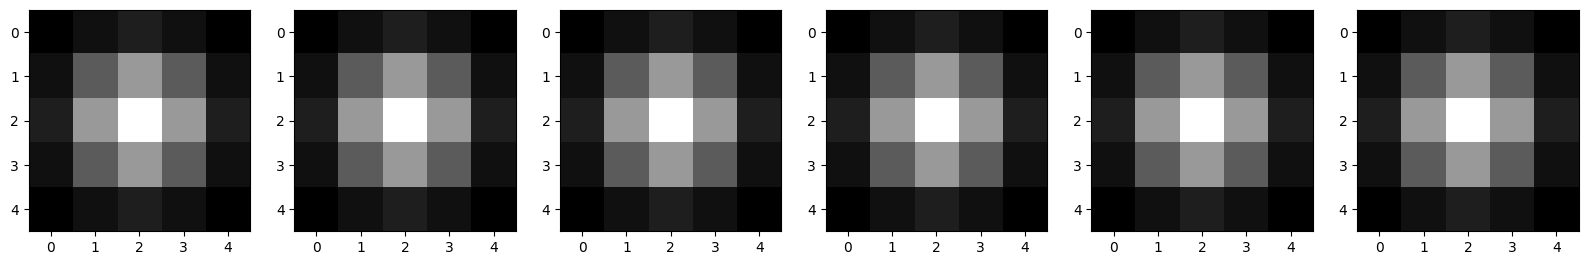

<Figure size 2000x500 with 0 Axes>

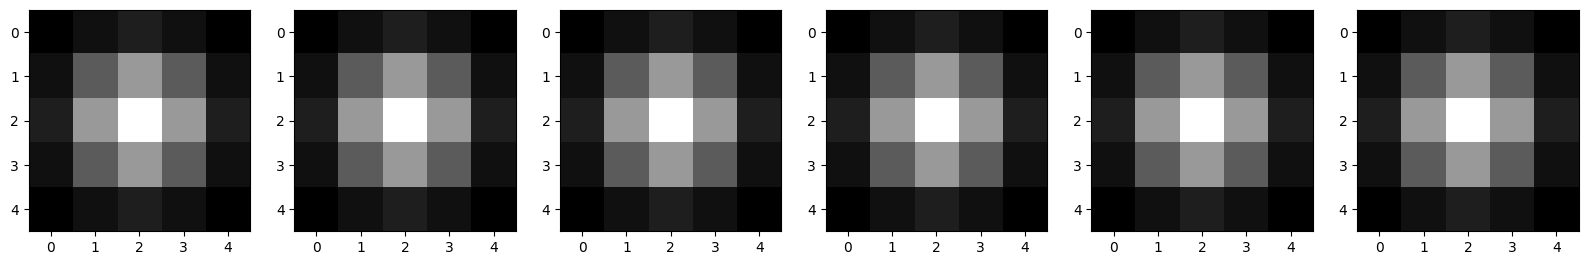

<Figure size 2000x500 with 0 Axes>

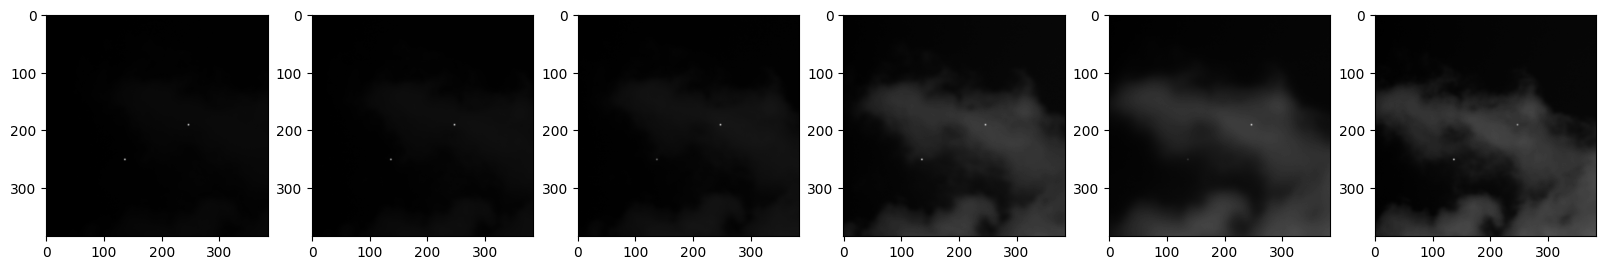

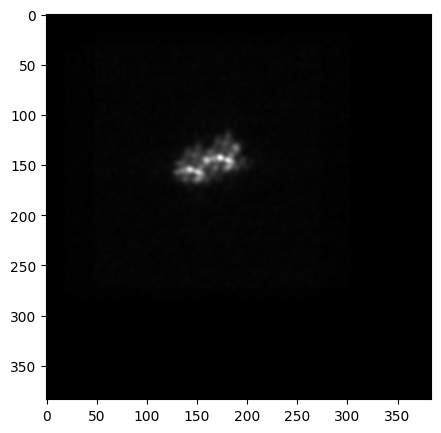

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils.PointSample_NoBG import gen_merge_sample
import cv2
import os
import json

otf_list = np.load("../data/PSF1110_6_IR_120_init.npy")
labels = [0,1,2,3,4,5]
obj_width = 5


[c,h,w] = otf_list.shape

expand_h = 384
expand_w = 384        
centerx = expand_w // 2
centery = expand_h // 2
pad_h_1 = (expand_h - h)//2
pad_h_2 = expand_h - h - pad_h_1
pad_w_1 = (expand_w - w)//2
pad_w_2 = expand_w - w - pad_w_1
otf_3d = np.pad(otf_list, ((0,0),(pad_h_1, pad_h_2),(pad_w_1,pad_w_2)),mode='constant', constant_values=0)
otf_fft = np.fft.fft2(np.fft.ifftshift(otf_3d,(1,2)))



sample, targets = gen_merge_sample(otf_fft, labels, obj_width, point_type="gauss", weight_mode = "rand")

count = len(targets)
print("{}个目标标签".format(count))
for t in targets:    
    print(t)


##############目标图样###########

for i in range(count):
    pt = np.load("debug/point_{}.npy".format(i))
    num, h,w = pt.shape
    plt.figure()
    plt.rcParams['figure.figsize'] = (20.0, 5.0)     
    fig, ax = plt.subplots(1,num)
    for j in range(num):
        ax[j].imshow(pt[j,:,:],cmap="gray")
        cv2.imwrite("debug/point_{}_{}.bmp".format(i, j), pt[j,:,:] * 255)


##############合成图样###########
rect_patch = np.load("debug/rect_patchs.npy")
num, h,w = rect_patch.shape
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
fig, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(rect_patch[i,:,:],cmap="gray")
    cv2.imwrite("debug/rect_patch_{}.bmp".format(i), rect_patch[i,:,:] * 255)


##############卷积结果###########
plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
plt.imshow(sample[0,:,:],cmap="gray")
cv2.imwrite("debug/sample.bmp".format(i), sample[0,:,:]/np.max(sample) * 255)


#############存储结果############
path = "debug"
np.save(os.path.join(path,"sample_{:05d}.npy".format(0)),sample)
with open(os.path.join(path,"sample_{:05d}.json".format(0)), "w") as fp:
    json.dump(targets, fp)


(384, 384) 0.5
(1, 384, 384)
[[3, 194, 194, 5, 5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5, -1, 192, 192]]


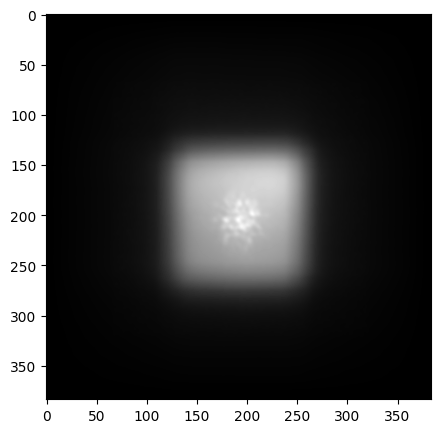

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lib.utils.PointSample_NoBG import gen_merge_sample
from lib.utils.BackgroundSample import gen_compressive_backgournd
import cv2

otf_file = "../data/psf_120_230801_180614_init.npy"
otf_list = np.load(otf_file)  
[c,h,w] = otf_list.shape

expand_h = 384
expand_w = 384        
centerx = expand_w // 2
centery = expand_h // 2
pad_h_1 = (expand_h - h)//2
pad_h_2 = expand_h - h - pad_h_1
pad_w_1 = (expand_w - w)//2
pad_w_2 = expand_w - w - pad_w_1
otf_3d = np.pad(otf_list, ((0,0),(pad_h_1, pad_h_2),(pad_w_1,pad_w_2)),mode='constant', constant_values=0)
otf_fft = np.fft.fft2(np.fft.ifftshift(otf_3d,(1,2)))

sky_bg = np.load("../data/background/center_128.npy")

crop_Intensity, prmse = gen_compressive_backgournd(otf_fft, sky_bg[0,:,:,:])


prmse = 0.5
print(crop_Intensity.shape, prmse)

labels = [3]
obj_len = 5

sample, target = gen_merge_sample(otf_fft, labels, obj_len, point_type="gauss", weight_mode = "onehot")
print(sample.shape)
print(target)
psnr = 40
img = sample[0,:,:] +  crop_Intensity/prmse * 10**(-psnr/20) 

# img = (img - np.min(img)) / (np.max(img)-np.min(img))
img = img/np.max(img)

plt.figure()
plt.rcParams['figure.figsize'] = (20.0, 5.0) 
plt.imshow(img,cmap="gray")
np.save("debug/sample.npy", img)


1.0 7.964853974323156e-18 1.0 1.8379498935987918e-17 3.3306690738754696e-16 -4.440892098500626e-16
0.10803393171768091 0.10803393171768094 -1.0737585084214482e-17


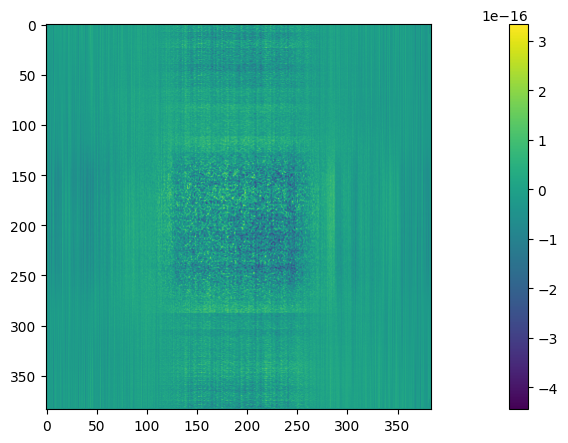

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
s1 = np.load('debug/sample_00000.npy')[0,:,:]
s2 = np.load('debug/sample.npy')
diff = s1 - s2
print(np.max(s1), np.min(s1), np.max(s2), np.min(s2), np.max(diff), np.min(diff))
print(np.mean(s1), np.mean(s2), np.mean(diff))


plt.figure(0)
plt.imshow(diff)
plt.colorbar()
plt.show()
